# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 10, 10, 10, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 10, 10, 10, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8425
Epoch 1/200, Iteration 2/12, Loss: 0.7720
Epoch 1/200, Iteration 3/12, Loss: 0.7450
Epoch 1/200, Iteration 4/12, Loss: 0.7294
Epoch 1/200, Iteration 5/12, Loss: 0.7022
Epoch 1/200, Iteration 6/12, Loss: 0.7253
Epoch 1/200, Iteration 7/12, Loss: 0.6868
Epoch 1/200, Iteration 8/12, Loss: 0.6336
Epoch 1/200, Iteration 9/12, Loss: 0.5223
Epoch 1/200, Iteration 10/12, Loss: 0.3908
Epoch 1/200, Iteration 11/12, Loss: 0.4607
Epoch 1/200, Iteration 12/12, Loss: 0.4187
Epoch 1/200, Iteration 13/12, Loss: 0.4297
Train Error: 
 Accuracy: 69.88%, Avg loss: 0.342426, MRE: 0.270928, MAE: 0.047901 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.329325, MRE: 0.229766, MAE: 0.045465 

Epoch 2/200, Iteration 1/12, Loss: 0.3381
Epoch 2/200, Iteration 2/12, Loss: 0.2873
Epoch 2/200, Iteration 3/12, Loss: 0.2685
Epoch 2/200, Iteration 4/12, Loss: 0.2983
Epoch 2/200, Iteration 5/12, Loss: 0.2911
Epoch 2/200, Iteration 6/12, Loss: 0.2471
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 88.88%, Avg loss: 0.075128, MRE: 0.060107, MAE: 0.009892 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.067223, MRE: 0.048757, MAE: 0.008640 

Epoch 13/200, Iteration 1/12, Loss: 0.0761
Epoch 13/200, Iteration 2/12, Loss: 0.0778
Epoch 13/200, Iteration 3/12, Loss: 0.0965
Epoch 13/200, Iteration 4/12, Loss: 0.0668
Epoch 13/200, Iteration 5/12, Loss: 0.0758
Epoch 13/200, Iteration 6/12, Loss: 0.0848
Epoch 13/200, Iteration 7/12, Loss: 0.0640
Epoch 13/200, Iteration 8/12, Loss: 0.0635
Epoch 13/200, Iteration 9/12, Loss: 0.0649
Epoch 13/200, Iteration 10/12, Loss: 0.0535
Epoch 13/200, Iteration 11/12, Loss: 0.0699
Epoch 13/200, Iteration 12/12, Loss: 0.0963
Epoch 13/200, Iteration 13/12, Loss: 0.0628
Train Error: 
 Accuracy: 93.25%, Avg loss: 0.066078, MRE: 0.053611, MAE: 0.008600 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.065580, MRE: 0.044630, MAE: 0.008229 

Epoch 14/200, Iteration 1/12, Loss: 0.0531
Epoch 14/200, Iteration 2/12, Loss: 0.0703
Epoch 14/200, Itera

Epoch 24/200, Iteration 12/12, Loss: 0.0404
Epoch 24/200, Iteration 13/12, Loss: 0.0855
Train Error: 
 Accuracy: 90.12%, Avg loss: 0.051783, MRE: 0.039304, MAE: 0.006638 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.046755, MRE: 0.033970, MAE: 0.005992 

Epoch 25/200, Iteration 1/12, Loss: 0.0556
Epoch 25/200, Iteration 2/12, Loss: 0.0486
Epoch 25/200, Iteration 3/12, Loss: 0.0563
Epoch 25/200, Iteration 4/12, Loss: 0.0588
Epoch 25/200, Iteration 5/12, Loss: 0.0543
Epoch 25/200, Iteration 6/12, Loss: 0.0457
Epoch 25/200, Iteration 7/12, Loss: 0.0545
Epoch 25/200, Iteration 8/12, Loss: 0.0555
Epoch 25/200, Iteration 9/12, Loss: 0.0585
Epoch 25/200, Iteration 10/12, Loss: 0.0492
Epoch 25/200, Iteration 11/12, Loss: 0.0593
Epoch 25/200, Iteration 12/12, Loss: 0.0608
Epoch 25/200, Iteration 13/12, Loss: 0.0594
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.062067, MRE: 0.042566, MAE: 0.007654 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.058552, MRE: 0.036908, MAE: 0.007084 

Epoch 26/200, Ite

Epoch 36/200, Iteration 10/12, Loss: 0.0410
Epoch 36/200, Iteration 11/12, Loss: 0.0315
Epoch 36/200, Iteration 12/12, Loss: 0.0475
Epoch 36/200, Iteration 13/12, Loss: 0.0465
Train Error: 
 Accuracy: 94.25%, Avg loss: 0.040130, MRE: 0.030224, MAE: 0.005016 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.034693, MRE: 0.024351, MAE: 0.004312 

Epoch 37/200, Iteration 1/12, Loss: 0.0379
Epoch 37/200, Iteration 2/12, Loss: 0.0437
Epoch 37/200, Iteration 3/12, Loss: 0.0520
Epoch 37/200, Iteration 4/12, Loss: 0.0461
Epoch 37/200, Iteration 5/12, Loss: 0.0433
Epoch 37/200, Iteration 6/12, Loss: 0.0398
Epoch 37/200, Iteration 7/12, Loss: 0.0444
Epoch 37/200, Iteration 8/12, Loss: 0.0419
Epoch 37/200, Iteration 9/12, Loss: 0.0313
Epoch 37/200, Iteration 10/12, Loss: 0.0324
Epoch 37/200, Iteration 11/12, Loss: 0.0383
Epoch 37/200, Iteration 12/12, Loss: 0.0376
Epoch 37/200, Iteration 13/12, Loss: 0.0491
Train Error: 
 Accuracy: 94.12%, Avg loss: 0.044434, MRE: 0.038613, MAE: 0.005354 

Test Error:

Train Error: 
 Accuracy: 97.12%, Avg loss: 0.034940, MRE: 0.028568, MAE: 0.004396 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.032868, MRE: 0.023597, MAE: 0.004112 

Epoch 49/200, Iteration 1/12, Loss: 0.0315
Epoch 49/200, Iteration 2/12, Loss: 0.0332
Epoch 49/200, Iteration 3/12, Loss: 0.0367
Epoch 49/200, Iteration 4/12, Loss: 0.0317
Epoch 49/200, Iteration 5/12, Loss: 0.0406
Epoch 49/200, Iteration 6/12, Loss: 0.0347
Epoch 49/200, Iteration 7/12, Loss: 0.0293
Epoch 49/200, Iteration 8/12, Loss: 0.0333
Epoch 49/200, Iteration 9/12, Loss: 0.0279
Epoch 49/200, Iteration 10/12, Loss: 0.0354
Epoch 49/200, Iteration 11/12, Loss: 0.0341
Epoch 49/200, Iteration 12/12, Loss: 0.0338
Epoch 49/200, Iteration 13/12, Loss: 0.0252
Train Error: 
 Accuracy: 95.88%, Avg loss: 0.034326, MRE: 0.025680, MAE: 0.004187 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.031217, MRE: 0.021846, MAE: 0.003725 

Epoch 50/200, Iteration 1/12, Loss: 0.0398
Epoch 50/200, Iteration 2/12, Loss: 0.0354
Epoch 50/200, Itera

Epoch 60/200, Iteration 9/12, Loss: 0.0243
Epoch 60/200, Iteration 10/12, Loss: 0.0220
Epoch 60/200, Iteration 11/12, Loss: 0.0295
Epoch 60/200, Iteration 12/12, Loss: 0.0178
Epoch 60/200, Iteration 13/12, Loss: 0.0297
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.024474, MRE: 0.020829, MAE: 0.002829 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.023073, MRE: 0.017910, MAE: 0.002634 

Epoch 61/200, Iteration 1/12, Loss: 0.0173
Epoch 61/200, Iteration 2/12, Loss: 0.0256
Epoch 61/200, Iteration 3/12, Loss: 0.0213
Epoch 61/200, Iteration 4/12, Loss: 0.0317
Epoch 61/200, Iteration 5/12, Loss: 0.0182
Epoch 61/200, Iteration 6/12, Loss: 0.0173
Epoch 61/200, Iteration 7/12, Loss: 0.0321
Epoch 61/200, Iteration 8/12, Loss: 0.0235
Epoch 61/200, Iteration 9/12, Loss: 0.0258
Epoch 61/200, Iteration 10/12, Loss: 0.0239
Epoch 61/200, Iteration 11/12, Loss: 0.0203
Epoch 61/200, Iteration 12/12, Loss: 0.0413
Epoch 61/200, Iteration 13/12, Loss: 0.0251
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.024582, 

Train Error: 
 Accuracy: 97.38%, Avg loss: 0.024013, MRE: 0.020409, MAE: 0.002764 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.023139, MRE: 0.018015, MAE: 0.002632 

Epoch 72/200, Iteration 1/12, Loss: 0.0218
Epoch 72/200, Iteration 2/12, Loss: 0.0207
Epoch 72/200, Iteration 3/12, Loss: 0.0252
Epoch 72/200, Iteration 4/12, Loss: 0.0216
Epoch 72/200, Iteration 5/12, Loss: 0.0270
Epoch 72/200, Iteration 6/12, Loss: 0.0305
Epoch 72/200, Iteration 7/12, Loss: 0.0327
Epoch 72/200, Iteration 8/12, Loss: 0.0251
Epoch 72/200, Iteration 9/12, Loss: 0.0243
Epoch 72/200, Iteration 10/12, Loss: 0.0206
Epoch 72/200, Iteration 11/12, Loss: 0.0198
Epoch 72/200, Iteration 12/12, Loss: 0.0181
Epoch 72/200, Iteration 13/12, Loss: 0.0307
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.024192, MRE: 0.020707, MAE: 0.002775 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.023376, MRE: 0.018051, MAE: 0.002628 

Epoch 73/200, Iteration 1/12, Loss: 0.0207
Epoch 73/200, Iteration 2/12, Loss: 0.0250
Epoch 73/200, Itera

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.025259, MRE: 0.022756, MAE: 0.002967 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.024065, MRE: 0.018249, MAE: 0.002764 

Epoch 84/200, Iteration 1/12, Loss: 0.0217
Epoch 84/200, Iteration 2/12, Loss: 0.0189
Epoch 84/200, Iteration 3/12, Loss: 0.0266
Epoch 84/200, Iteration 4/12, Loss: 0.0234
Epoch 84/200, Iteration 5/12, Loss: 0.0258
Epoch 84/200, Iteration 6/12, Loss: 0.0246
Epoch 84/200, Iteration 7/12, Loss: 0.0355
Epoch 84/200, Iteration 8/12, Loss: 0.0271
Epoch 84/200, Iteration 9/12, Loss: 0.0224
Epoch 84/200, Iteration 10/12, Loss: 0.0230
Epoch 84/200, Iteration 11/12, Loss: 0.0242
Epoch 84/200, Iteration 12/12, Loss: 0.0245
Epoch 84/200, Iteration 13/12, Loss: 0.0213
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.024142, MRE: 0.021009, MAE: 0.002857 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.023636, MRE: 0.017306, MAE: 0.002760 

Epoch 85/200, Iteration 1/12, Loss: 0.0234
Epoch 85/200, Iteration 2/12, Loss: 0.0239
Epoch 85/200, Iterat

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.022434, MRE: 0.016997, MAE: 0.002537 

Epoch 96/200, Iteration 1/12, Loss: 0.0243
Epoch 96/200, Iteration 2/12, Loss: 0.0183
Epoch 96/200, Iteration 3/12, Loss: 0.0204
Epoch 96/200, Iteration 4/12, Loss: 0.0266
Epoch 96/200, Iteration 5/12, Loss: 0.0284
Epoch 96/200, Iteration 6/12, Loss: 0.0248
Epoch 96/200, Iteration 7/12, Loss: 0.0219
Epoch 96/200, Iteration 8/12, Loss: 0.0229
Epoch 96/200, Iteration 9/12, Loss: 0.0219
Epoch 96/200, Iteration 10/12, Loss: 0.0262
Epoch 96/200, Iteration 11/12, Loss: 0.0163
Epoch 96/200, Iteration 12/12, Loss: 0.0275
Epoch 96/200, Iteration 13/12, Loss: 0.0205
Train Error: 
 Accuracy: 97.5%, Avg loss: 0.023221, MRE: 0.020289, MAE: 0.002673 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.021335, MRE: 0.016782, MAE: 0.002405 

Epoch 97/200, Iteration 1/12, Loss: 0.0216
Epoch 97/200, Iteration 2/12, Loss: 0.0246
Epoch 97/200, Iteration 3/12, Loss: 0.0232
Epoch 97/200, Iteration 4/12, Loss: 0.0203
Epoch 97/200, Iter

Epoch 107/200, Iteration 4/12, Loss: 0.0287
Epoch 107/200, Iteration 5/12, Loss: 0.0228
Epoch 107/200, Iteration 6/12, Loss: 0.0183
Epoch 107/200, Iteration 7/12, Loss: 0.0245
Epoch 107/200, Iteration 8/12, Loss: 0.0219
Epoch 107/200, Iteration 9/12, Loss: 0.0231
Epoch 107/200, Iteration 10/12, Loss: 0.0278
Epoch 107/200, Iteration 11/12, Loss: 0.0198
Epoch 107/200, Iteration 12/12, Loss: 0.0196
Epoch 107/200, Iteration 13/12, Loss: 0.0226
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.022927, MRE: 0.020183, MAE: 0.002643 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.021555, MRE: 0.016605, MAE: 0.002431 

Epoch 108/200, Iteration 1/12, Loss: 0.0214
Epoch 108/200, Iteration 2/12, Loss: 0.0243
Epoch 108/200, Iteration 3/12, Loss: 0.0201
Epoch 108/200, Iteration 4/12, Loss: 0.0211
Epoch 108/200, Iteration 5/12, Loss: 0.0380
Epoch 108/200, Iteration 6/12, Loss: 0.0264
Epoch 108/200, Iteration 7/12, Loss: 0.0184
Epoch 108/200, Iteration 8/12, Loss: 0.0297
Epoch 108/200, Iteration 9/12, Loss: 0

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.021788, MRE: 0.022396, MAE: 0.002545 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.020452, MRE: 0.015684, MAE: 0.002314 

Epoch 119/200, Iteration 1/12, Loss: 0.0229
Epoch 119/200, Iteration 2/12, Loss: 0.0265
Epoch 119/200, Iteration 3/12, Loss: 0.0217
Epoch 119/200, Iteration 4/12, Loss: 0.0290
Epoch 119/200, Iteration 5/12, Loss: 0.0209
Epoch 119/200, Iteration 6/12, Loss: 0.0183
Epoch 119/200, Iteration 7/12, Loss: 0.0261
Epoch 119/200, Iteration 8/12, Loss: 0.0221
Epoch 119/200, Iteration 9/12, Loss: 0.0198
Epoch 119/200, Iteration 10/12, Loss: 0.0173
Epoch 119/200, Iteration 11/12, Loss: 0.0200
Epoch 119/200, Iteration 12/12, Loss: 0.0312
Epoch 119/200, Iteration 13/12, Loss: 0.0167
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.022389, MRE: 0.019996, MAE: 0.002622 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.021074, MRE: 0.015876, MAE: 0.002404 

Epoch 120/200, Iteration 1/12, Loss: 0.0232
Epoch 120/200, Iteration 2/12, Loss: 0.0211
Epo

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.021826, MRE: 0.019102, MAE: 0.002548 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.020288, MRE: 0.015419, MAE: 0.002364 

Epoch 131/200, Iteration 1/12, Loss: 0.0149
Epoch 131/200, Iteration 2/12, Loss: 0.0181
Epoch 131/200, Iteration 3/12, Loss: 0.0185
Epoch 131/200, Iteration 4/12, Loss: 0.0244
Epoch 131/200, Iteration 5/12, Loss: 0.0249
Epoch 131/200, Iteration 6/12, Loss: 0.0274
Epoch 131/200, Iteration 7/12, Loss: 0.0260
Epoch 131/200, Iteration 8/12, Loss: 0.0235
Epoch 131/200, Iteration 9/12, Loss: 0.0215
Epoch 131/200, Iteration 10/12, Loss: 0.0280
Epoch 131/200, Iteration 11/12, Loss: 0.0208
Epoch 131/200, Iteration 12/12, Loss: 0.0210
Epoch 131/200, Iteration 13/12, Loss: 0.0191
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.022046, MRE: 0.019115, MAE: 0.002573 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.020765, MRE: 0.015817, MAE: 0.002391 

Epoch 132/200, Iteration 1/12, Loss: 0.0242
Epoch 132/200, Iteration 2/12, Loss: 0.0192
Epoch

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.020822, MRE: 0.018632, MAE: 0.002394 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019489, MRE: 0.015052, MAE: 0.002201 

Epoch 143/200, Iteration 1/12, Loss: 0.0243
Epoch 143/200, Iteration 2/12, Loss: 0.0159
Epoch 143/200, Iteration 3/12, Loss: 0.0202
Epoch 143/200, Iteration 4/12, Loss: 0.0185
Epoch 143/200, Iteration 5/12, Loss: 0.0164
Epoch 143/200, Iteration 6/12, Loss: 0.0196
Epoch 143/200, Iteration 7/12, Loss: 0.0221
Epoch 143/200, Iteration 8/12, Loss: 0.0236
Epoch 143/200, Iteration 9/12, Loss: 0.0265
Epoch 143/200, Iteration 10/12, Loss: 0.0200
Epoch 143/200, Iteration 11/12, Loss: 0.0170
Epoch 143/200, Iteration 12/12, Loss: 0.0274
Epoch 143/200, Iteration 13/12, Loss: 0.0187
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.020601, MRE: 0.018729, MAE: 0.002370 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019431, MRE: 0.015042, MAE: 0.002198 

Epoch 144/200, Iteration 1/12, Loss: 0.0231
Epoch 144/200, Iteration 2/12, Loss: 0.0232
Epoc

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.020550, MRE: 0.018397, MAE: 0.002373 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019447, MRE: 0.015016, MAE: 0.002200 

Epoch 155/200, Iteration 1/12, Loss: 0.0203
Epoch 155/200, Iteration 2/12, Loss: 0.0217
Epoch 155/200, Iteration 3/12, Loss: 0.0176
Epoch 155/200, Iteration 4/12, Loss: 0.0160
Epoch 155/200, Iteration 5/12, Loss: 0.0245
Epoch 155/200, Iteration 6/12, Loss: 0.0270
Epoch 155/200, Iteration 7/12, Loss: 0.0217
Epoch 155/200, Iteration 8/12, Loss: 0.0177
Epoch 155/200, Iteration 9/12, Loss: 0.0258
Epoch 155/200, Iteration 10/12, Loss: 0.0167
Epoch 155/200, Iteration 11/12, Loss: 0.0203
Epoch 155/200, Iteration 12/12, Loss: 0.0184
Epoch 155/200, Iteration 13/12, Loss: 0.0198
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.020681, MRE: 0.018934, MAE: 0.002381 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019452, MRE: 0.015022, MAE: 0.002200 

Epoch 156/200, Iteration 1/12, Loss: 0.0275
Epoch 156/200, Iteration 2/12, Loss: 0.0171
Epoc

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019443, MRE: 0.015017, MAE: 0.002199 

Epoch 166/200, Iteration 1/12, Loss: 0.0168
Epoch 166/200, Iteration 2/12, Loss: 0.0236
Epoch 166/200, Iteration 3/12, Loss: 0.0193
Epoch 166/200, Iteration 4/12, Loss: 0.0208
Epoch 166/200, Iteration 5/12, Loss: 0.0188
Epoch 166/200, Iteration 6/12, Loss: 0.0213
Epoch 166/200, Iteration 7/12, Loss: 0.0176
Epoch 166/200, Iteration 8/12, Loss: 0.0245
Epoch 166/200, Iteration 9/12, Loss: 0.0178
Epoch 166/200, Iteration 10/12, Loss: 0.0211
Epoch 166/200, Iteration 11/12, Loss: 0.0186
Epoch 166/200, Iteration 12/12, Loss: 0.0222
Epoch 166/200, Iteration 13/12, Loss: 0.0304
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.020477, MRE: 0.018255, MAE: 0.002355 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019442, MRE: 0.015015, MAE: 0.002199 

Epoch 167/200, Iteration 1/12, Loss: 0.0199
Epoch 167/200, Iteration 2/12, Loss: 0.0196
Epoch 167/200, Iteration 3/12, Loss: 0.0214
Epoch 167/200, Iteration 4/12, Loss: 0.0167

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.020574, MRE: 0.018416, MAE: 0.002373 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019441, MRE: 0.015014, MAE: 0.002199 

Epoch 178/200, Iteration 1/12, Loss: 0.0162
Epoch 178/200, Iteration 2/12, Loss: 0.0203
Epoch 178/200, Iteration 3/12, Loss: 0.0226
Epoch 178/200, Iteration 4/12, Loss: 0.0232
Epoch 178/200, Iteration 5/12, Loss: 0.0184
Epoch 178/200, Iteration 6/12, Loss: 0.0196
Epoch 178/200, Iteration 7/12, Loss: 0.0247
Epoch 178/200, Iteration 8/12, Loss: 0.0171
Epoch 178/200, Iteration 9/12, Loss: 0.0196
Epoch 178/200, Iteration 10/12, Loss: 0.0163
Epoch 178/200, Iteration 11/12, Loss: 0.0245
Epoch 178/200, Iteration 12/12, Loss: 0.0274
Epoch 178/200, Iteration 13/12, Loss: 0.0151
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.020537, MRE: 0.018436, MAE: 0.002361 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019441, MRE: 0.015014, MAE: 0.002199 

Epoch 179/200, Iteration 1/12, Loss: 0.0189
Epoch 179/200, Iteration 2/12, Loss: 0.0240
Epoc

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.020941, MRE: 0.018771, MAE: 0.002411 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019441, MRE: 0.015014, MAE: 0.002199 

Epoch 190/200, Iteration 1/12, Loss: 0.0160
Epoch 190/200, Iteration 2/12, Loss: 0.0285
Epoch 190/200, Iteration 3/12, Loss: 0.0209
Epoch 190/200, Iteration 4/12, Loss: 0.0177
Epoch 190/200, Iteration 5/12, Loss: 0.0303
Epoch 190/200, Iteration 6/12, Loss: 0.0189
Epoch 190/200, Iteration 7/12, Loss: 0.0182
Epoch 190/200, Iteration 8/12, Loss: 0.0204
Epoch 190/200, Iteration 9/12, Loss: 0.0155
Epoch 190/200, Iteration 10/12, Loss: 0.0186
Epoch 190/200, Iteration 11/12, Loss: 0.0162
Epoch 190/200, Iteration 12/12, Loss: 0.0245
Epoch 190/200, Iteration 13/12, Loss: 0.0239
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.020524, MRE: 0.018519, MAE: 0.002370 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.019441, MRE: 0.015014, MAE: 0.002199 

Epoch 191/200, Iteration 1/12, Loss: 0.0163
Epoch 191/200, Iteration 2/12, Loss: 0.0186
Epoc

#### Plots loss vs Epoch

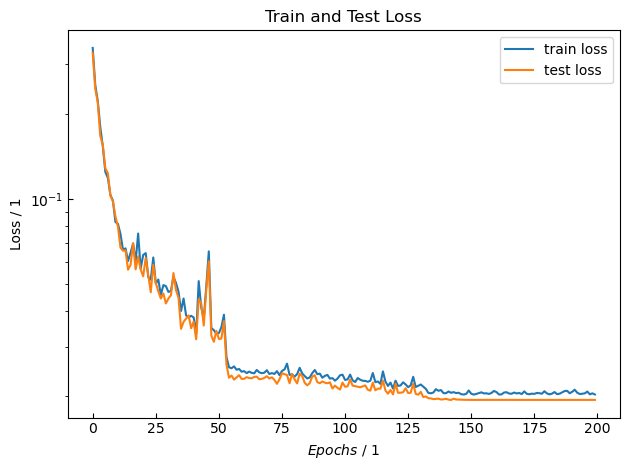

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9994400639707572 , R^2(NH3) = 0.9959382146415883
Test Dataset: R^2(H2) = 0.9994547014238648 , R^2(NH3) = 0.9986015185304901
Max Error Training: |x_H2 - x_H2,pred| = 0.06730986270443584 , |x_NH3 - x_NH3,pred| = 0.06099704480419779
Max Error Test: |x_H2 - x_H2,pred| = 0.029905094145944777 , |x_NH3 - x_NH3,pred| = 0.014432481212792503


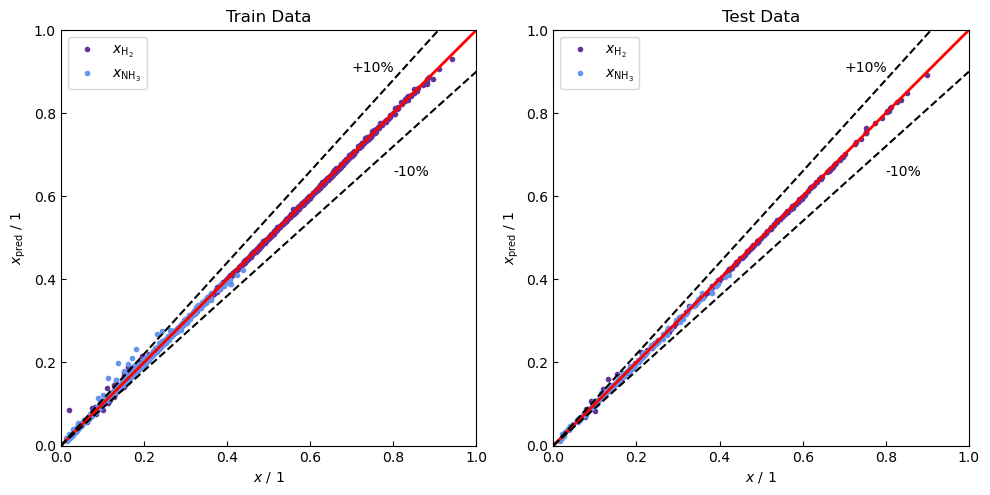

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

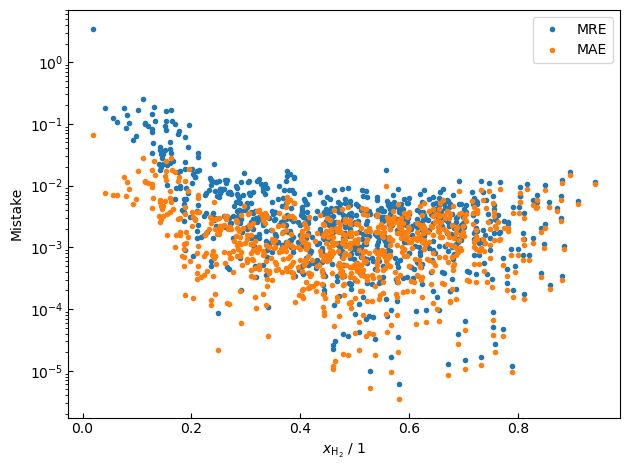

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

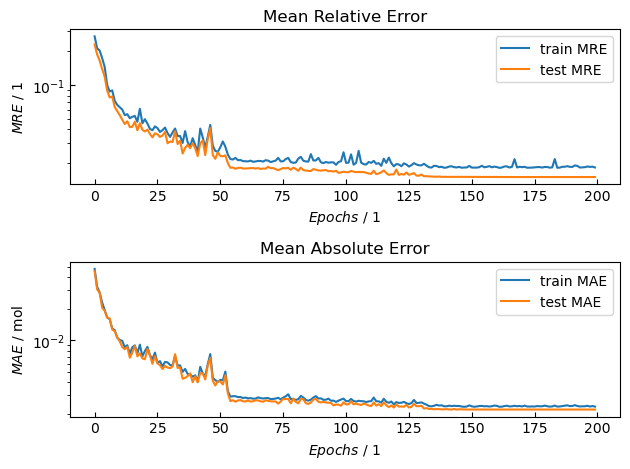

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

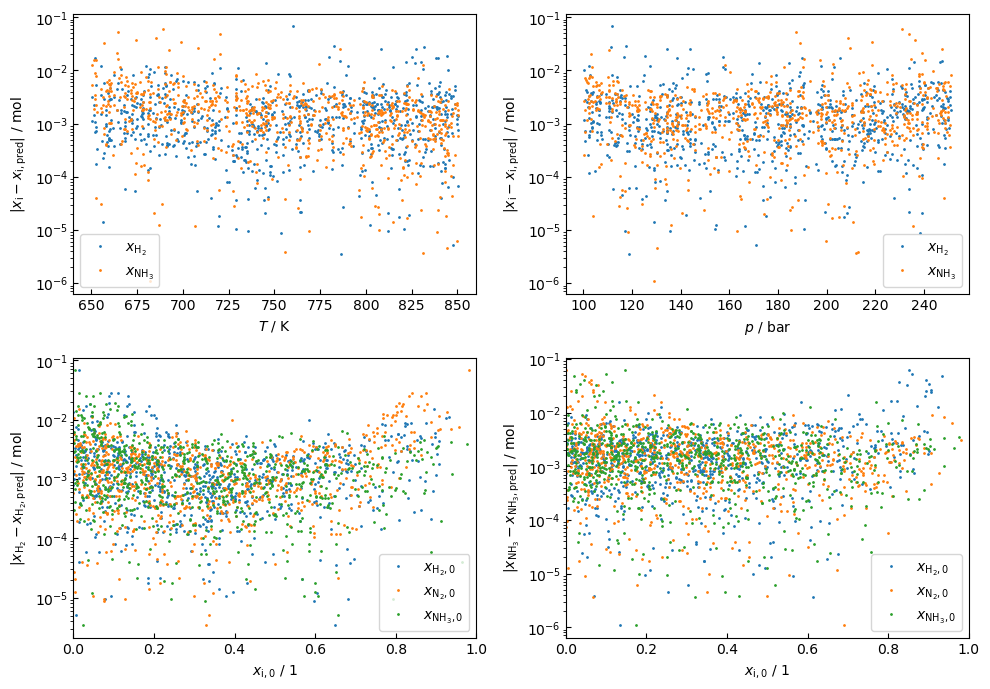

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

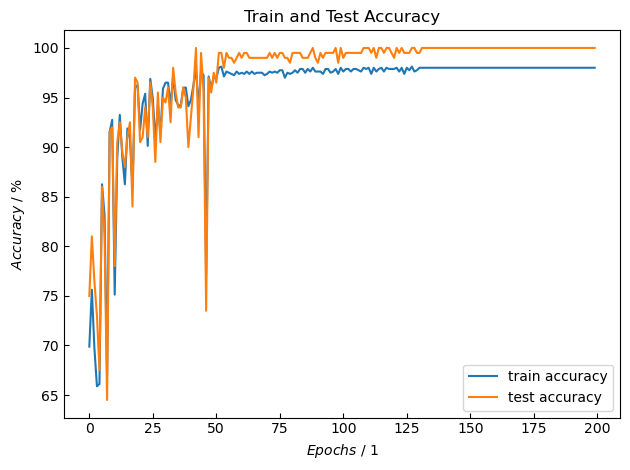

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-3.5059e-01, -3.5045e-02, -6.4317e-03, -3.6549e-01,  3.7987e-01],
        [-1.3109e+00, -3.2260e-01, -9.6364e-01,  5.3583e-01,  3.9804e-01],
        [ 8.4721e-01, -1.3921e+00,  1.0627e-01, -9.7729e-01,  8.9457e-01],
        [-7.9671e-01,  7.7665e-01,  2.4775e+00, -1.1109e+00, -1.2959e+00],
        [-9.5612e-01,  9.8330e-01,  2.4496e+00, -1.1231e+00, -1.2561e+00],
        [ 1.4667e+00,  2.5792e-01, -8.7940e-01,  4.0229e-01,  4.5186e-01],
        [-1.4937e+00,  1.2425e+00, -5.4250e-02, -7.9974e-01,  8.7063e-01],
        [ 8.0894e-01, -8.4765e-01,  4.1474e-01,  2.5508e-01, -6.6772e-01],
        [ 4.7153e-02, -9.8757e-01, -1.3713e+00,  1.8218e+00, -5.1619e-01],
        [-7.2814e-01, -1.4142e+00,  2.4807e-01,  6.1483e-01, -8.7185e-01],
        [-1.4215e+00, -1.3630e+00,  2.8609e-01, -1.2044e+00,  9.5021e-01],
        [-7.4248e-01, -1.0883e+00,  6.1900e-02,  7.9642e-01, -8.7475e-01],
        [-1.3906e+00, -5.3899e-01,  4.7933e-01, -4.4863e-01, -1.1879e-02],
        [ 1.5618e+00, -2.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.0487, -0.0081,  0.1990, -0.2926,  0.2202],
         [ 0.4243, -0.1453, -0.0985,  0.1003, -0.1821],
         [ 0.2393, -0.0783,  0.0944, -0.5199, -0.0286],
         [ 0.1002,  0.1878, -0.4448,  0.0131, -0.2855],
         [-0.0617,  0.0236,  0.1569,  0.1402, -0.1662],
         [-0.0328, -0.1807, -0.1182,  0.5696,  0.1174],
         [-0.5666,  0.1579,  0.1344,  0.2932,  0.1803],
         [-0.3085,  0.0818,  0.1199, -0.4809,  0.0417],
         [-0.0854,  0.0198, -0.1315,  0.0118,  0.2629],
         [-0.2804,  0.1307,  0.2213, -0.3732, -0.0531]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3034, -0.0244,  0.2321,  0.4873, -0.6286,  1.0358, -0.9753,  0.1534,
          0.0091, -0.2626], requires_grad=True),
 Parameter containing:
 tensor([[-0.4222, -0.1362, -0.4046,  0.2794, -0.1122,  0.4930,  0.1957,  0.2502,
          -0.0879,  0.2187],
         [ 0.5294, -0.8295,  0.1768, -0.2186, -0.4955,  0.0279, -0.4252,  0.2976,
          -0.0250, -0.0681

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0553, 0.9423, 0.9978, 0.6340, 0.6001],
        [0.8612, 0.1014, 0.2243, 0.6253, 0.3797]])
tensor([[-0.0728,  0.5517],
        [ 0.0516, -0.6278]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 9.5982e-03, -2.4183e-01,  7.4297e-01,  1.3177e-01, -8.6382e-01],
        [ 4.5691e-01, -5.5252e-01,  3.0555e-01,  9.5331e-01, -1.2742e+00],
        [ 5.4986e-01, -1.6670e+00,  1.4947e+00, -8.9629e-01, -5.5084e-01],
        [ 9.8788e-01,  2.3590e-02,  1.2986e-01,  7.4224e-01, -8.8607e-01],
        [-1.4601e+00,  4.0222e-01,  8.9972e-01, -7.6124e-01, -1.0493e-01],
        [ 1.0016e+00,  1.2363e+00, -6.7881e-01, -1.3856e+00,  2.0823e+00],
        [ 1.3533e+00,  7.9419e-01,  4.7907e-01, -8.3650e-01,  3.8482e-01],
        [-3.4584e-01,  4.2744e-01, -7.6888e-01,  1.6674e+00, -9.4961e-01],
        [ 1.6174e+00, -3.9528e-02,  1.4976e+00, -8.5383e-01, -5.9703e-01],
        [-4.4500e-01, -3.9885e-02,  1.8517e-02,  6.9030e-01, -7.2371e-01],
        [-2.5687e-01,  1.4539e+00,  2.1698e+00, -1.2085e+00, -8.9425e-01],
        [-1.6303e+00, -8.9618e-01, -5.8100e-01,  1.2246e+00, -6.8142e-01],
        [ 5.5718e-03,  8.5302e-01, -1.1338e+00,  6.8181e-01,  4.1580e-01],
        [ 5.4985e-01,  7.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()